# Import and Install Dependencies

In [92]:
pip install opencv-python imageio gdown

Note: you may need to restart the kernel to use updated packages.


In [1]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio

In [2]:
tf.config.list_physical_devices('GPU')#i only have a integrated gpu so no device for gpu

[]

In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass # no gpu for me so it will pass

# Building Data Loading functions

In [4]:
import gdown

In [5]:
def load_video(path:str) -> List[float]: 

    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))): 
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236,80:220,:])
    cap.release()
    
    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    mean = tf.cast(mean, tf.float32)
    std = tf.cast(std, tf.float32)
    return (frames - mean) / std

In [6]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [7]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size =40)


In [8]:
char_to_num.get_vocabulary()

['',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 "'",
 '?',
 '!',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ' ']

In [9]:
#character to numerical value
char_to_num(['h','e','b','l','i','n'])

<tf.Tensor: shape=(6,), dtype=int64, numpy=array([ 8,  5,  2, 12,  9, 14], dtype=int64)>

In [10]:
#numerical value to character
num_to_char([8,  5,  2, 12,  9, 14])

<tf.Tensor: shape=(6,), dtype=string, numpy=array([b'h', b'e', b'b', b'l', b'i', b'n'], dtype=object)>

In [11]:
tf.strings.reduce_join([num_to_char([8,  5,  2, 12,  9, 14])])

<tf.Tensor: shape=(), dtype=string, numpy=b'heblin'>

In [12]:
def load_alignments(path:str) -> List[str]: 
    with open(path, 'r') as f: 
        lines = f.readlines() 
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil': 
            tokens = [*tokens,' ',line[2]]
    #return char_to_num(tokens)[1:]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [13]:
def load_data(path:str): 
    path = bytes.decode(path.numpy())
    #file_name = path.split('/')[-1].split('.')[0]
    file_name = os.path.splitext(os.path.basename(path))[0]
    video_path = os.path.join('data','s1',f'{file_name}.mpg')
    alignment_path = os.path.join('data','alignments','s1',f'{file_name}.align')
    frames = load_video(video_path) 
    alignments = load_alignments(alignment_path) 
    return frames, alignments

In [14]:
test_path = './data/s1/bbal6n.mpg'

In [15]:
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('/')[-1].split('.')[0]

'bbal6n'

In [16]:
import tensorflow as tf
print(tf.__version__)


2.16.1


In [17]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))

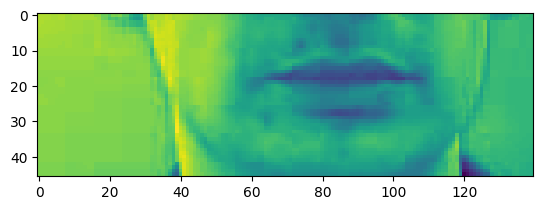

In [18]:
plt.imshow(frames[0])

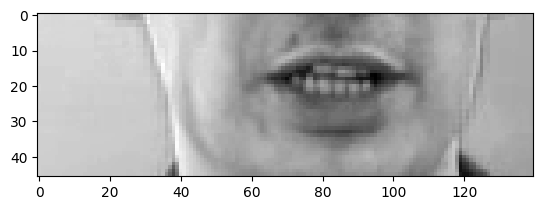

In [19]:
if len(frames) > 40:
    plt.imshow(tf.squeeze(frames[40]), cmap='gray')
    plt.show()
else:
    print("Frame index out of bounds.")

In [20]:
alignments

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39, 12, 39, 19,  9, 24,
       39, 14, 15, 23], dtype=int64)>

In [21]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()]) 

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at l six now'>

In [22]:
def mappable_function(path:str) -> List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result2

# Create Pipeline

In [23]:
data = tf.data.Dataset.list_files('./data/s1/*.mpg')
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes = ([75, None, None, None], [40]))
data = data.prefetch(tf.data.AUTOTUNE)
train = data.take(450)
test = data.skip(450)

In [24]:
for batch in train.take(1):
    x_batch, y_batch = batch
    print("Shape of x_batch:", x_batch.shape)
    print("Shape of y_batch:", y_batch.shape)


Shape of x_batch: (2, 75, 46, 140, 1)
Shape of y_batch: (2, 40)


In [25]:
len(test)

50

In [26]:
frames, alignments = data.as_numpy_iterator().next()

In [27]:
len(frames)

2

In [28]:
alignments

array([[16, 12,  1,  3,  5, 39,  2, 12, 21,  5, 39, 23,  9, 20,  8, 39,
        10, 39,  6,  9, 22,  5, 39,  1,  7,  1,  9, 14,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0],
       [19,  5, 20, 39,  2, 12, 21,  5, 39, 23,  9, 20,  8, 39, 21, 39,
        19,  5, 22,  5, 14, 39,  1,  7,  1,  9, 14,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0]], dtype=int64)

In [29]:
sample = data.as_numpy_iterator()

In [30]:
val = sample.next()
val[0]

array([[[[[ 1.3937719 ],
          [ 1.3937719 ],
          [ 1.3937719 ],
          ...,
          [ 0.73560184],
          [ 0.9678971 ],
          [ 0.61945415]],

         [[ 1.3937719 ],
          [ 1.3937719 ],
          [ 1.3937719 ],
          ...,
          [ 0.9291812 ],
          [ 0.8904654 ],
          [ 0.5420224 ]],

         [[ 1.3163401 ],
          [ 1.3163401 ],
          [ 1.3163401 ],
          ...,
          [ 0.73560184],
          [ 0.9291812 ],
          [-0.03871588]],

         ...,

         [[ 1.0453289 ],
          [ 0.9678971 ],
          [ 0.9678971 ],
          ...,
          [ 0.07743177],
          [ 0.03871588],
          [ 0.        ]],

         [[ 0.9678971 ],
          [ 0.9678971 ],
          [ 0.9678971 ],
          ...,
          [ 0.03871588],
          [ 0.03871588],
          [ 0.        ]],

         [[ 0.9678971 ],
          [ 0.9678971 ],
          [ 0.9678971 ],
          ...,
          [ 0.03871588],
          [ 0.        ],
          

In [ ]:
imageio.mimsave('./animation.gif', val[0][1], fps =10)

TypeError: Cannot handle this data type: (1, 1, 1), <f4

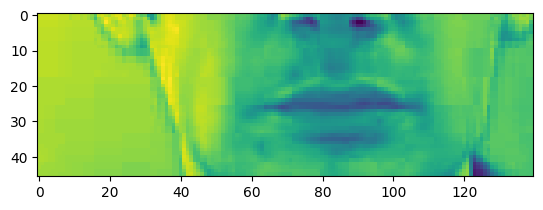

In [31]:
##videos,videos out of batch, return first frame in the video
plt.imshow(val[0][0][0])

In [32]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'set red with i four please'>

# Design Deep Neural Network

In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape,Lambda, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.initializers import Orthogonal 

In [34]:
data.as_numpy_iterator().next()[0][0].shape

(75, 46, 140, 1)

In [35]:
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding = 'same'))
model.add(Activation('relu'))
model.add(MaxPool3D(pool_size=(1, 2, 2)))

model.add(Conv3D(256, 3, padding = 'same'))
model.add(Activation('relu'))
model.add(MaxPool3D(pool_size=(1, 2, 2)))

model.add(Conv3D(75, 3, padding = 'same'))
model.add(Activation('relu'))
model.add(MaxPool3D(pool_size=(1, 2, 2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer='orthogonal', return_sequences = True)))
model.add(Dropout(0.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='orthogonal', return_sequences = True)))
model.add(Dropout(0.5))

model.add(Dense(char_to_num.vocabulary_size()+ 1, kernel_initializer='he_normal', activation='softmax'))


c:\Users\hebli\anaconda3\envs\env1\lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [36]:
46*140*75

483000

In [37]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                 │ (None, 75, 46, 140,    │         3,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 75, 46, 140,    │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 75, 23, 70,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 75, 23, 70,     │       884,992 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 75, 23, 70,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 75, 11, 35,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 75, 11, 35, 75) │       518,475 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 75, 11, 35, 75) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 75, 5, 17, 75)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 75, 6375)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 75, 256)        │     6,660,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 75, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 75, 256)        │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 75, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 75, 41)         │        10,537 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,471,924 (32.32 MB)

 Trainable params: 8,471,924 (32.32 MB)

 Non-trainable params: 0 (0.00 B)

In [38]:
yhat = model.predict(val[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


In [39]:
#model before train
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'??????yyyyyyyyyyyyyyykkkkkkkkkkkkkkkkkkkkkkwwwwwwwwwwwwwkkkkkkkkkkkkkkkkkkk'>

In [40]:
model.input_shape

(None, 75, 46, 140, 1)

In [41]:
model.output_shape

(None, 75, 41)

# Setup Training Options and Train

In [42]:
def scheduler(epochs, lr):
    if epochs < 30:
        return lr
    else:
        return lr*tf.math.exp(-0.1)

In [43]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = tf.expand_dims(input_length * tf.ones(shape=(batch_len,), dtype='int64'), axis=-1)
    label_length = tf.expand_dims(label_length * tf.ones(shape=(batch_len,), dtype='int64'), axis=-1)

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [44]:
class ProduceExample(tf.keras.callbacks.Callback):
    def __init__(self, dataset) -> None:
        self.dataset = dataset.as_numpy_iterator()

    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False )[0][0].numpy()
        for x in range(len(yhat)):
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [45]:
model.compile(optimizer = Adam(learning_rate = 0.0001), loss = CTCLoss)

In [46]:
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint.weights.h5'),monitor = 'loss', save_weights_only = True)

In [47]:
schedule_callback = LearningRateScheduler(scheduler)

In [52]:
example_callback = ProduceExample(test)

In [49]:
model.fit(train, validation_data=test, epochs=100, callbacks=[checkpoint_callback, schedule_callback, example_callback])

Epoch 1/100


KeyboardInterrupt: 

# Make a Prediction

In [54]:
model.load_weights('./models/checkpoint')

ValueError: File format not supported: filepath=./models/checkpoint. Keras 3 only supports V3 `.keras` and `.weights.h5` files, or legacy V1/V2 `.h5` files.

In [154]:
test_data = test.as_numpy_iterator()


In [155]:
sample = test_data.next()

In [156]:
yhat = model.predict(sample[0])

1/1 [==============================] - 0s 398ms/step


In [157]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy()

In [158]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b's ree at s sive again'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'lea re it i sive again'>]

In [159]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'lay red in y one soon'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'place red at c seven soon'>]

# Test On a Video

In [176]:
sample = load_data(tf.convert_to_tensor('./data/s1/bras9a.mpg'))

In [177]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin red at s nine again'>]

In [178]:
yhat = model.predict(tf.expand_dims(sample[0], axis=0))

1/1 [==============================] - 0s 227ms/step


In [179]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()

In [180]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'se reen it a sive again'>]